In [28]:
import sys
import numpy as np
from jsme_notebook import JSMENotebook
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import CIRconvert, inference_predict, fp_from_smiles, mol_predict_and_std

In [42]:
import time
t0 = time.time()
y_test_avg_predict_dict, std_dict, rmsd_dict = mol_predict_and_std(["linear", "KRR", "GB", "RF", "ANN"], fp_from_smiles(obach_split["train"]["Drug"]), fp_from_smiles(obach_split["test"]["Drug"]), train_halflives_scaled, test_halflives_scaled)
t1 = time.time()
dt = t1 - t0
print(t0, t1)
print(dt)
print(rmsd_dict)

     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best KRR hyperparams: KernelRidge(alpha=0.0011288378916846883, gamma=4.281332398719387e-08,
            kernel='laplacian')
     best KRR hyperparams: KernelRidge(alpha=0.0011288378916846883, gamma=2.3357214690901212e-07,
            kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=0.07847599703514607, gamma=1.4384498882876659e-09,
            kernel='rbf')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, max_depth=1, n_estimators=400)
     best RF hyperparams: RandomForestRegressor(max_depth=2, max_features='sqrt')
     best RF hyperparams: RandomForestRegressor(max_depth=2, max_features='lo

In [41]:
for model_id in ["linear", "KRR", "GB", "RF", "ANN"]:
    print(model_id)
    print(spearmanr(y_test_avg_predict_dict[model_id], test_halflives_scaled))

linear
SignificanceResult(statistic=nan, pvalue=nan)
KRR
SignificanceResult(statistic=0.21330343975532579, pvalue=0.013695417335635398)
GB
SignificanceResult(statistic=0.28038484009540304, pvalue=0.0010798207974230898)
RF
SignificanceResult(statistic=0.25871705553599844, pvalue=0.0026394898525907732)
ANN
SignificanceResult(statistic=0.1282539894523765, pvalue=0.14123203134384307)


In [27]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

import optuna

X, y = load_iris(return_X_y=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
classes = np.unique(y)
n_train_iter = 100


def objective(trial):
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    clf = SGDClassifier(alpha=alpha)

    for step in range(n_train_iter):
        clf.partial_fit(X_train, y_train, classes=classes)

        intermediate_value = clf.score(X_valid, y_valid)
        trial.report(intermediate_value, step)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return clf.score(X_valid, y_valid)

samplers = {
    'RandomSampler': optuna.samplers.RandomSampler,          # Sampler that selects hyperparameters randomly from the search space.
    'GridSampler': optuna.samplers.GridSampler,              # Sampler that performs a grid search over the hyperparameter space.
    'TPESampler': optuna.samplers.TPESampler,                # Sampler that uses a tree-structured Parzen estimator to model the objective function and sample new points from the search space.
    'CmaEsSampler': optuna.samplers.CmaEsSampler,            # Sampler that uses the Covariance Matrix Adaptation Evolution Strategy algorithm to efficiently search the hyperparameter space.
    'NSGAIISampler': optuna.samplers.NSGAIISampler,          # Multi-objective evolutionary algorithm that generates new samples using non-dominated sorting and crowding distance selection.
    'QMCSampler': optuna.samplers.QMCSampler,                # Quasi-Monte Carlo sampler that uses low-discrepancy sequences to sample the search space in a more efficient and evenly distributed way than random sampling.
    'BoTorchSampler': optuna.integration.BoTorchSampler,     # Sampler that leverages the BoTorch library for Bayesian optimization and can handle both continuous and categorical hyperparameters.
    'BruteForceSampler': optuna.samplers.BruteForceSampler,  # Sampler that exhaustively evaluates all possible combinations of hyperparameters in the search space.
}

pruners = {
    'BasePruner': optuna.pruners.BasePruner,                            # This is the base class for all pruning strategies in Optuna. It provides a skeleton for implementing custom pruning strategies.
    'MedianPruner': optuna.pruners.MedianPruner,                        # A pruner that prunes unpromising trials that have median objective values, as determined in previous steps.
    'SuccessiveHalvingPruner': optuna.pruners.SuccessiveHalvingPruner,  # This pruner repeatedly splits trials into halves, discarding the lower performing half at each iteration.
    'HyperbandPruner': optuna.pruners.HyperbandPruner,                  # This pruner implements the Hyperband algorithm, which selects promising trials and runs them with different resource allocation schemes to determine the best one.
    'PercentilePruner': optuna.pruners.PercentilePruner,                # A pruner that prunes unpromising trials based on their percentile rank relative to all completed trials.
    'NopPruner': optuna.pruners.NopPruner,                              # A pruner that does nothing and does not prune any trials.
    'ThresholdPruner': optuna.pruners.ThresholdPruner,                  # This pruner prunes trials that have not reached a certain level of performance (i.e., objective value).
    'PatientPruner': optuna.pruners.PatientPruner,                      # This pruner prunes trials that do not show improvement over a certain number of steps (or epochs).
}

sampler = samplers["TPESampler"]
pruner = pruners["HyperbandPruner"]
study = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    pruner=pruner
)
study.optimize(objective, n_trials=20)
fig = optuna.visualization.plot_timeline(study)
fig.show()

[I 2024-02-21 18:47:32,931] A new study created in memory with name: no-name-2a70d8eb-2d52-4d4b-a2ce-6732e16c22b9


TypeError: TPESampler.before_trial() missing 1 required positional argument: 'trial'

In [2]:
from tdc.single_pred import ADME
obach = ADME(name='Half_Life_Obach')
obach_split = obach.get_split()
microsome = ADME(name='Clearance_Microsome_AZ')
microsome_split = microsome.get_split()
hepatocyte = ADME(name='Clearance_Hepatocyte_AZ')
hepatocyte_split = hepatocyte.get_split()

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [11]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

def param_tuning(x_train, x_test, y_train, y_test, type_ml_use):
    # !!! určování hodnot pro param tuning, lze vylepšit pomocí np.random.randint

    if type_ml_use == 'linear':
        param_grid = {
            'fit_intercept': [True],
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
            'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
        }
        reg = ElasticNet(alpha=0.0424, l1_ratio=0.7398)

    if type_ml_use == 'KRR':
        param_grid = {
            "alpha": np.logspace(-4, 1, 20),
            "gamma": np.logspace(-14, 0, 20),
            "kernel": ['linear', 'laplacian', 'rbf']
        }
        reg = KernelRidge(alpha=0.56, gamma=2.5e-15, kernel="laplacian")

    if type_ml_use == 'GB':
        param_grid = {
            'n_estimators': [10, 20, 50, 200, 400],
            'learning_rate': [0.02, 0.05],
            'max_depth': [1, 2, 3, 5],
        }
        reg = GradientBoostingRegressor()

    if type_ml_use == 'RF':
        param_grid = {
            'max_depth': [None, 2, 3, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_estimators': [10, 20, 50, 100, 200],
        }
        reg = RandomForestRegressor()

    if type_ml_use == 'ANN':
        param_grid = {
            'learning_rate_init': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05],
            'hidden_layer_sizes': [[5], [10], [20], [50], [5]*2, [10]*2, [20]*2, [50]*2, [5]*3, [10]*3]
        }
        reg = MLPRegressor()

    """grid = RandomizedSearchCV(reg, param_grid, cv=KFold(n_splits=5, shuffle=True), verbose=0)
    grid.fit(x_train, y_train)
    best_reg = grid.best_estimator_
    # retrain on best hyperparameters"""
    reg.fit(x_train, y_train)
    y_train_predict = reg.predict(x_train)
    y_test_predict = reg.predict(x_test)
    abs_error = np.abs(y_test_predict-y_test)
    print(f"     best {type_ml_use} hyperparams: {reg}")

    return y_train_predict, y_test_predict, abs_error

In [12]:
from scipy.stats import spearmanr

y_train = obach_split["train"]["Y"]
y_test = obach_split["test"]["Y"]

y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)


reshaped_train_halflife = np.array(y_train).reshape(-1, 1)
scaler = MinMaxScaler().fit(reshaped_train_halflife)
train_halflife_scaled = scaler.transform(reshaped_train_halflife)
train_halflives_scaled = np.array([val[0] for val in train_halflife_scaled])

reshaped_test_halflife = np.array(y_test).reshape(-1, 1)
scaler = MinMaxScaler().fit(reshaped_test_halflife)
test_halflife_scaled = scaler.transform(reshaped_test_halflife)
test_halflives_scaled = np.array([val[0] for val in test_halflife_scaled])


y_train_predict, y_test_predict, abs_error = param_tuning(fp_from_smiles(obach_split["train"]["Drug"]), fp_from_smiles(obach_split["test"]["Drug"]), y_train, y_test, "KRR")
rmsd = np.sqrt(np.average(np.square(y_test_predict-y_test)))
spearman = spearmanr(y_test, y_test_predict).statistic
print("normal")
print(f"rmsd: {round(rmsd, 3)}, spearman: {round(spearman, 3)}")

y_train_predict, y_test_predict_ln, abs_error = param_tuning(fp_from_smiles(obach_split["train"]["Drug"]), fp_from_smiles(obach_split["test"]["Drug"]), y_train_ln, y_test_ln, "KRR")
rmsd_ln = np.sqrt(np.average(np.square(y_test_predict_ln-y_test_ln)))
spearman_ln = spearmanr(y_test_ln, y_test_predict_ln).statistic
print("natural log")
print(f"rmsd: {round(rmsd_ln, 3)}, spearman: {round(spearman_ln, 3)}")

y_train_predict, y_test_predict_scaled, abs_error = param_tuning(fp_from_smiles(obach_split["train"]["Drug"]), fp_from_smiles(obach_split["test"]["Drug"]), train_halflives_scaled, test_halflives_scaled, "KRR")
rmsd_scaled = np.sqrt(np.average(np.square(y_test_predict_scaled-test_halflives_scaled)))
spearman_scaled = spearmanr(test_halflives_scaled, y_test_predict_scaled).statistic
print("MinMaxScaler")
print(f"rmsd: {round(rmsd_scaled, 3)}, spearman: {round(spearman_scaled, 3)}")

     best KRR hyperparams: KernelRidge(alpha=0.56, gamma=2.5e-15, kernel='laplacian')
normal
rmsd: 120.645, spearman: 0.24
     best KRR hyperparams: KernelRidge(alpha=0.56, gamma=2.5e-15, kernel='laplacian')
natural log
rmsd: 1.517, spearman: 0.331
     best KRR hyperparams: KernelRidge(alpha=0.56, gamma=2.5e-15, kernel='laplacian')
MinMaxScaler
rmsd: 0.143, spearman: 0.239


In [12]:
obach_all = obach_split["train"]["Y"] + obach_split["test"]["Y"] + obach_split["valid"]["Y"]
microsome_all = microsome_split["train"]["Y"] + microsome_split["test"]["Y"] + microsome_split["valid"]["Y"]
hepatocyte_all = hepatocyte_split["train"]["Y"] + hepatocyte_split["test"]["Y"] + hepatocyte_split["valid"]["Y"]

print(min(obach_all), min(microsome_all), min(hepatocyte_all))
print(max(obach_all), max(microsome_all), max(hepatocyte_all))

4.11 9.0 9.0
855.3 351.0 325.1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
from tdc.single_pred import ADME
from project_resources.cytochrome_P450 import fp_from_smiles

# Load data
obach = ADME(name='Half_Life_Obach')
obach_split = obach.get_split()

X_smi = np.array(obach_split["train"]["Drug"])
X = np.array(fp_from_smiles(X_smi))
y = np.array(obach_split["train"]["Y"])
#y = np.array(y).reshape(-1, 1)
#scaler = MinMaxScaler().fit(y)
#y_scaled = scaler.transform(y)
#y = np.array([val[0] for val in y_scaled])

# Fit a gradient boosting regressor
regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
regressor.fit(X, y)

# Visualize decision boundaries for the first few trees
num_trees_to_visualize = 100
display_trees = [99]
for i in range(num_trees_to_visualize):
    if i in display_trees:
        tree_num = i + 1
        plt.figure(figsize=(16, 9))
        plot_tree(regressor.estimators_[i][0], filled=True, feature_names=[f'Feature {i}' for i in range(X.shape[1])])
        plt.title("Příklad rozhodovacího stromu ze souboru slabých žáků GB regrese")
        plt.savefig("project_results/graphs/GB_decision_tree.png")
        plt.show()

ModuleNotFoundError: No module named 'project_resources.cytochrome_P450'

0.4904761904761905


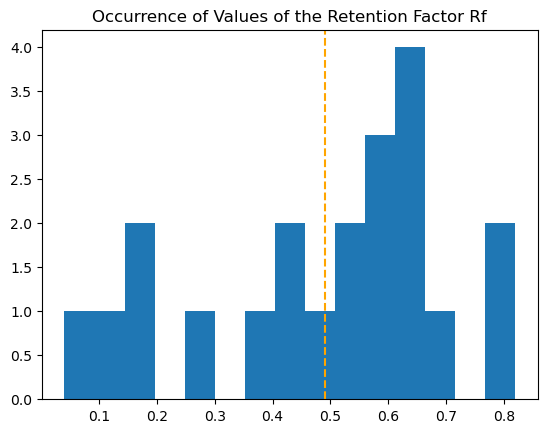

In [12]:
values = [
    0.18, 0.42, 0.55, 0.82,
    0.18, 0.49, 0.60, 0.71,
    0.29, 0.61, 0.81,
    0.45, 0.51, 0.60, 0.64,
    0.04, 0.62, 0.64,
    0.14, 0.36, 0.64
]
print(np.mean(values))

plt.title("Occurrence of Values of the Retention Factor Rf")
plt.hist(values, bins=15)
plt.axvline(np.mean(values), linestyle="dashed", color="orange")

In [23]:
smiles = [('Brc1ccc2NC(=O)CN=C(c3ccccn3)c2c1', 'bromazepam'),
 ('CC(=O)Nc1ccc(O)cc1', 'paracetamol'),
 ('CC(C)Cc1ccc(cc1)C(C)C(O)=O', 'ibuprofen'),
 ('O.O.O.CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)C(=O)N2[C@H]1C(O)=O',
  'amoxicillin'),
 ('O.O.NCCCC[C@H](N[C@@H](CCc1ccccc1)C(O)=O)C(=O)N2CCC[C@H]2C(O)=O',
  'lisinopril'),
 ('CC(C)c1n(CC[C@@H](O)C[C@@H](O)CC(O)=O)c(c2ccc(F)cc2)c(c3ccccc3)c1C(=O)Nc4ccccc4',
  'atorvastatin'),
 ('[H+].[Cl-].CN(C)C(=N)N=C(N)N', 'metformin'),
 ('COc1ccc2nc([nH]c2c1)[S](=O)Cc3ncc(C)c(OC)c3C', 'omeprazole'),
 ('CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H]12',
  'simvastatin'),
 ('OC1N=C(c2ccccc2Cl)c3cc(Cl)ccc3NC1=O', 'lorazepam'),
 ('CNCCC(Oc1ccc(cc1)C(F)(F)F)c2ccccc2', 'fluoxetine'),
 ('CN(C)CCCC1(OCc2cc(ccc12)C#N)c3ccc(F)cc3', 'citalopram'),
 ('CNC(/NCCSCc1oc(CN(C)C)cc1)=C\\[N+]([O-])=O', 'ranitidine'),
 ('[Cl-].COc1cccc(c1)[C@@]2(O)CCCC[C@@H]2CN(C)C.[H+]', 'tramadol'),
 ('[Cl-].CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c3ccccc13.[H+]', 'sertraline'),
 ('NCC1(CCCCC1)CC(O)=O', 'gabapentin'),
 ('COc1ccc2cc(ccc2c1)C(C)C(O)=O', 'naproxen'),
 ('COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'clopidogrel'),
 ('COc1ccnc(C[S](=O)c2[nH]c3cc(OC(F)F)ccc3n2)c1OC', 'pantoprazole'),
 ('NC(Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(O)=O', 'levothyroxine')]

Found local copy...
Loading...
Done!


bromazepam


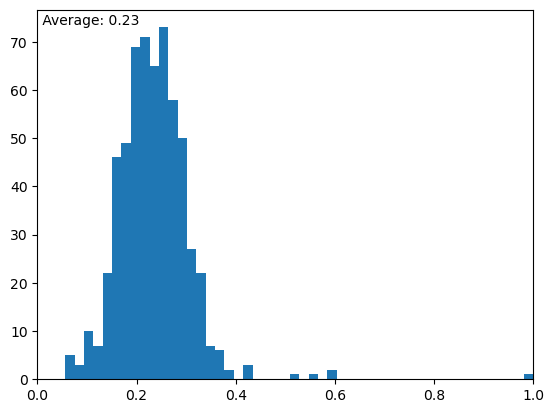

Found local copy...
Loading...
Done!


[15.62518348]
paracetamol


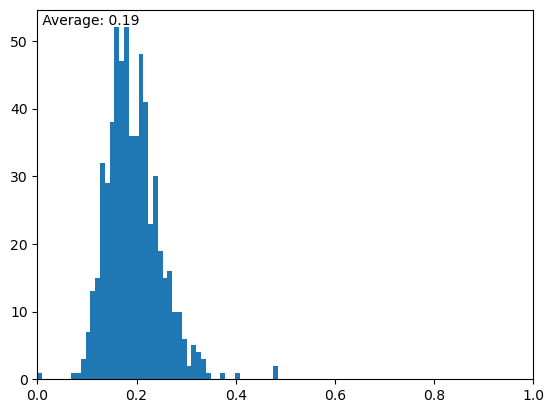

Found local copy...
Loading...
Done!


[15.62518348]
ibuprofen


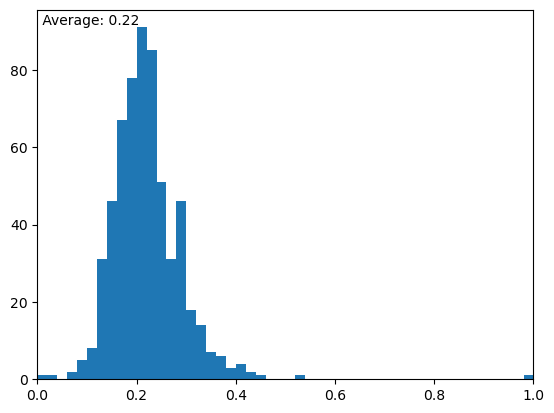

Found local copy...
Loading...
Done!


[15.62518348]
amoxicillin


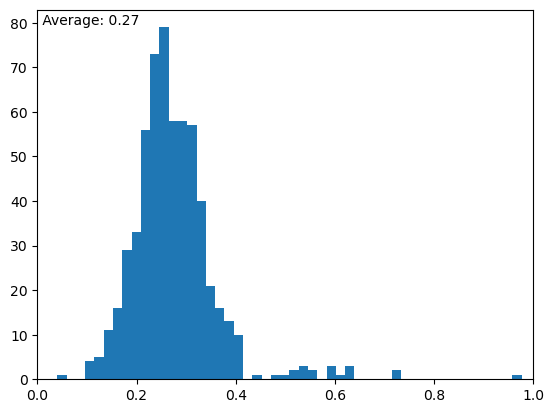

Found local copy...
Loading...
Done!


[15.62518348]
lisinopril


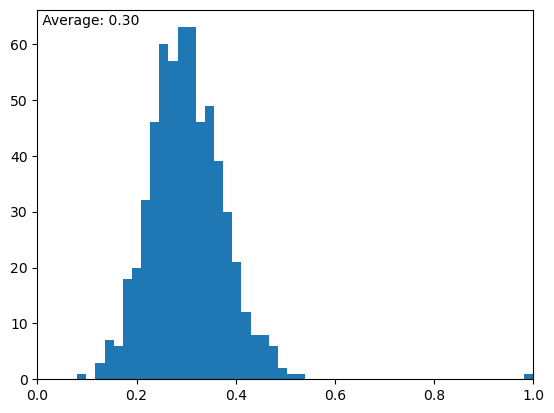

Found local copy...
Loading...
Done!


[15.62518348]
atorvastatin


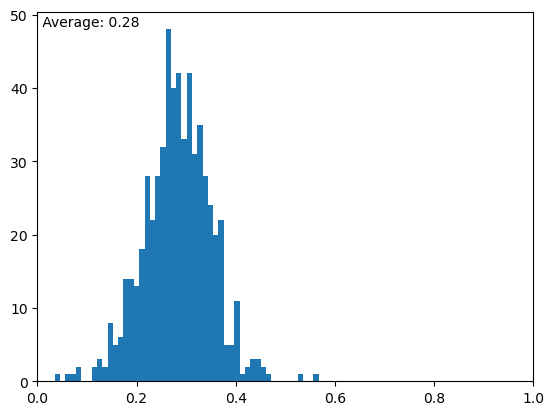

Found local copy...
Loading...
Done!


[18.96753744]
metformin


[07:39:40] WARNING: not removing hydrogen atom without neighbors


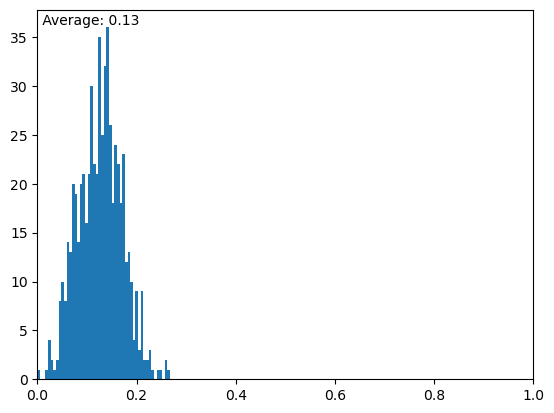

Found local copy...
Loading...
Done!


[15.62518348]
omeprazole


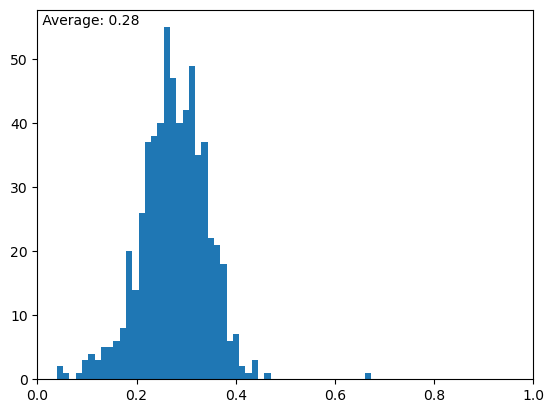

Found local copy...
Loading...
Done!


[26.8811067]
simvastatin


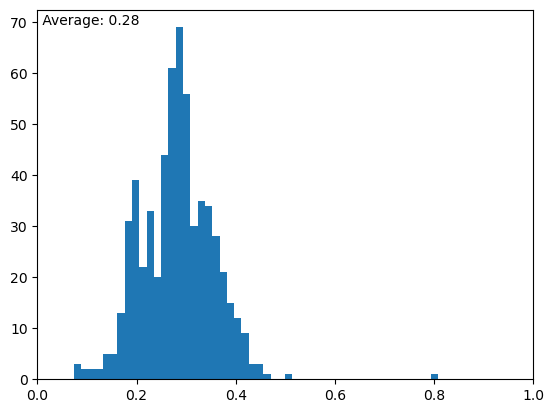

Found local copy...
Loading...
Done!


[23.53875273]
lorazepam


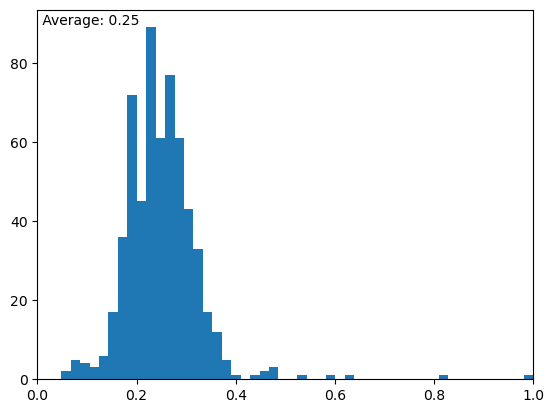

Found local copy...
Loading...
Done!


[18.96753744]
fluoxetine


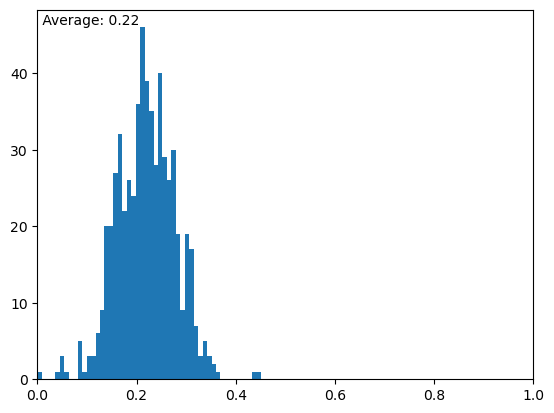

Found local copy...
Loading...


[15.62518348]
citalopram


Done!


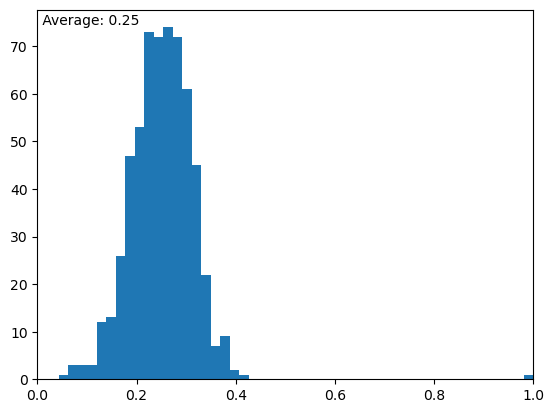

Found local copy...
Loading...
Done!


[15.62518348]
ranitidine


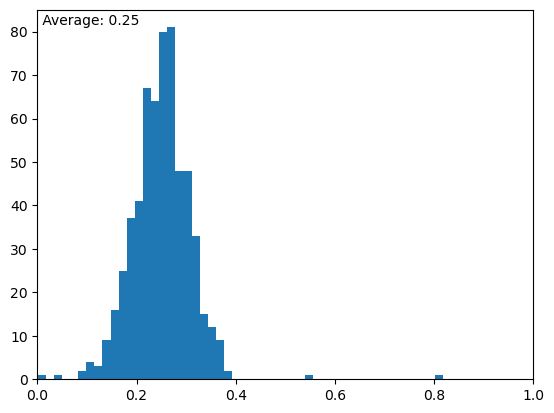

Found local copy...
Loading...
Done!


[15.62518348]
tramadol


[07:39:52] WARNING: not removing hydrogen atom without neighbors


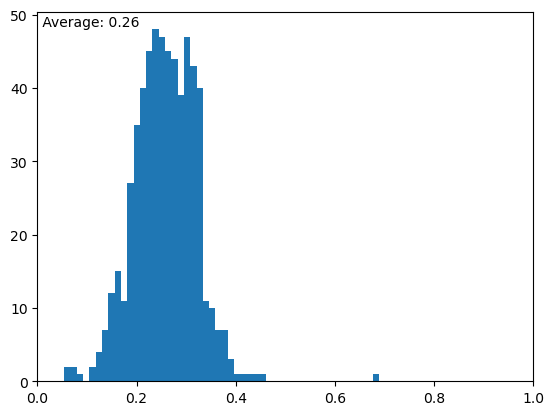

Found local copy...
Loading...
Done!


[15.62518348]
sertraline


[07:39:53] WARNING: not removing hydrogen atom without neighbors


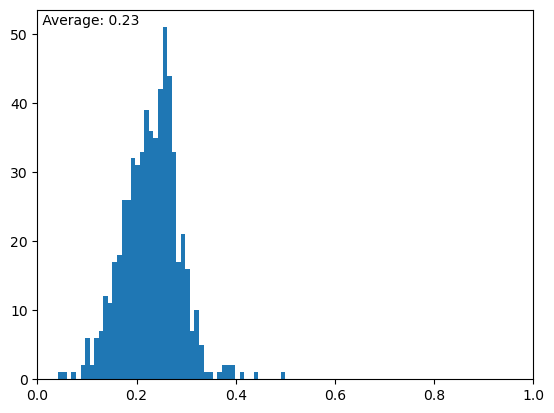

Found local copy...
Loading...
Done!


[15.62518348]
gabapentin


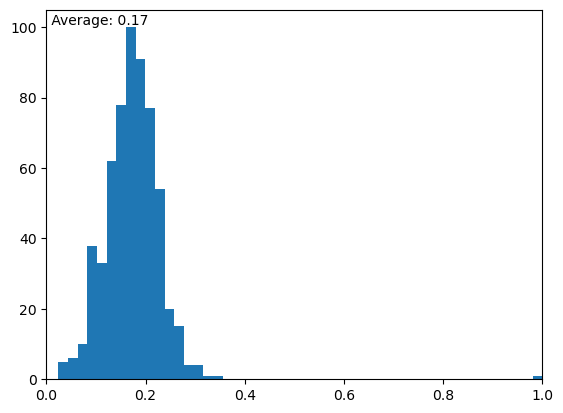

Found local copy...
Loading...
Done!


[23.53875273]
naproxen


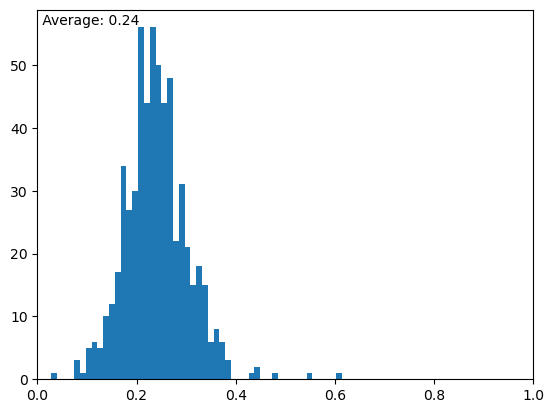

Found local copy...
Loading...
Done!


[15.62518348]
clopidogrel


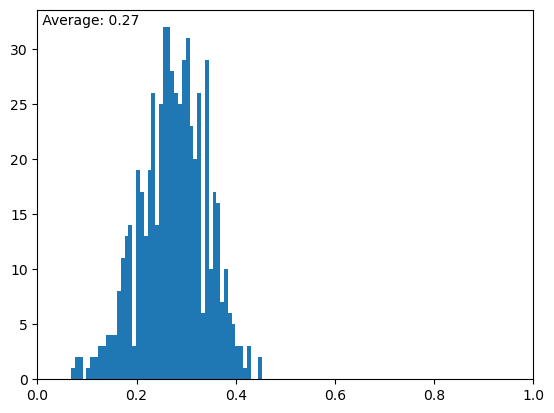

Found local copy...
Loading...
Done!


[23.53875273]
pantoprazole


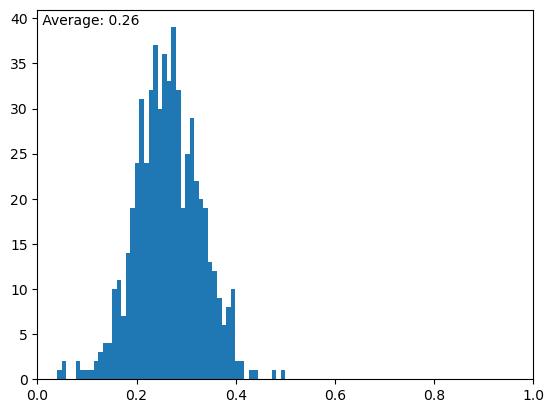

Found local copy...
Loading...
Done!


[26.8811067]
levothyroxine


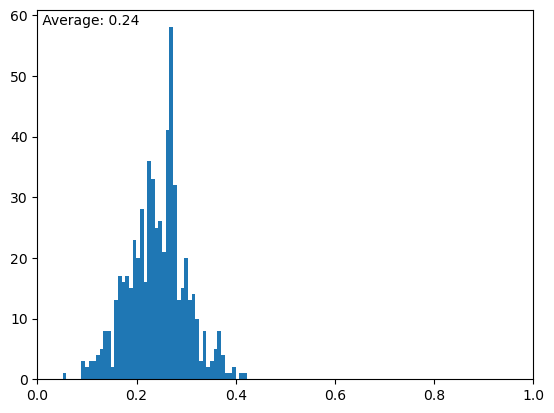

[15.62518348]


In [3]:
for smi, name in smiles:
    print(name)
    inference_predict("morgan", "obach", "GB", smi)